In [ ]:
import zipfile
import os

In [ ]:
fruits= zipfile.ZipFile("/content/drive/MyDrive/fruits-360.zip")
fruits.extractall("/tmp")
fruits.close()


In [ ]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# Creating the Pathlib PATH objects
train_path = Path("/tmp/fruits-360/Training")
test_path = Path("/tmp/fruits-360/Test")

In [ ]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/tmp/fruits-360/Training/Corn Husk/281_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/r_31_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/r_246_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/r_74_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/r_15_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/172_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/229_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/280_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/119_100.jpg',
 '/tmp/fruits-360/Training/Corn Husk/r_187_100.jpg']

In [ ]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['Corn Husk',
 'Corn Husk',
 'Corn Husk',
 'Corn Husk',
 'Corn Husk',
 'Corn Husk',
 'Corn Husk',
 'Corn Husk',
 'Corn Husk',
 'Corn Husk']

In [ ]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36])

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels)

In [ ]:
Train_paths[:10] , Train_labels[:10]

(['/tmp/fruits-360/Training/Nut Forest/r_209_100.jpg',
  '/tmp/fruits-360/Training/Strawberry Wedge/264_100.jpg',
  '/tmp/fruits-360/Training/Banana Red/r_81_100.jpg',
  '/tmp/fruits-360/Training/Grape White 4/r_28_100.jpg',
  '/tmp/fruits-360/Training/Pepper Orange/r_16_100.jpg',
  '/tmp/fruits-360/Training/Quince/65_100.jpg',
  '/tmp/fruits-360/Training/Grape Blue/251_100.jpg',
  '/tmp/fruits-360/Training/Avocado ripe/r_296_100.jpg',
  '/tmp/fruits-360/Training/Cucumber Ripe/98_100.jpg',
  '/tmp/fruits-360/Training/Fig/r2_85_100.jpg'],
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [ ]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 224 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, -0.2))
])

In [ ]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 418 ms, sys: 23.4 ms, total: 442 ms
Wall time: 528 ms
(32, 224, 224, 3)
(32, 131)


Pepper Red


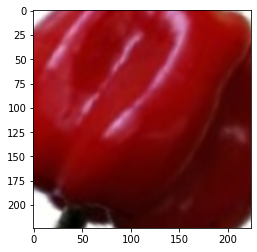

In [ ]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 33.9 ms, sys: 920 µs, total: 34.8 ms
Wall time: 34.4 ms
(32, 224, 224, 3)
(32, 131)


Kumquats


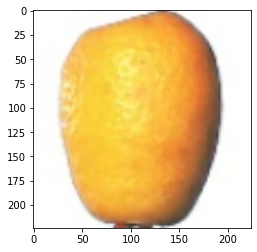

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [ ]:
# Building EfficientNetB3
from tensorflow.keras.applications import EfficientNetB3

backbone = EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(131, activation='softmax')
])

model.summary()

43950080/43941136 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dense_1 (Dense)             (None, 131)               16899     
                                                                 
Total params: 10,997,170
Trainable params: 10,909,867
N

In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=1,
    #callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
)

1586/1586 [==============================] - 1071s 659ms/step - loss: 0.3813 - accuracy: 0.9015 - precision: 0.9506 - recall: 0.8735 - val_loss: 0.6632 - val_accuracy: 0.8411 - val_precision: 0.8656 - val_recall: 0.8277


In [ ]:
model.layers[0].trainable = False

In [ ]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dense_1 (Dense)             (None, 131)               16899     
                                                                 
Total params: 10,997,170
Trainable params: 213,635
Non-trainable params: 10,783,535
____________________________________

In [ ]:
# Train phase 2 of model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=4,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
)

Epoch 1/4
1586/1586 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9758 - precision: 0.9792 - recall: 0.9724
Epoch 00001: val_loss improved from inf to 0.55522, saving model to best_weights.h5
1586/1586 [==============================] - 1041s 656ms/step - loss: 0.0861 - accuracy: 0.9758 - precision: 0.9792 - recall: 0.9724 - val_loss: 0.5552 - val_accuracy: 0.8881 - val_precision: 0.8983 - val_recall: 0.8802
Epoch 2/4
1586/1586 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9820 - precision: 0.9840 - recall: 0.9801
Epoch 00002: val_loss did not improve from 0.55522
1586/1586 [==============================] - 1045s 658ms/step - loss: 0.0651 - accuracy: 0.9820 - precision: 0.9840 - recall: 0.9801 - val_loss: 1.5592 - val_accuracy: 0.6554 - val_precision: 0.7048 - val_recall: 0.6318
Epoch 3/4
1586/1586 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9824 - precision: 0.9842 - recall: 0.9810
Epoch 00003: val_loss d

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

backbone = EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(131, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model.load_weights("best_weights.h5")

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 131)


Corn Husk


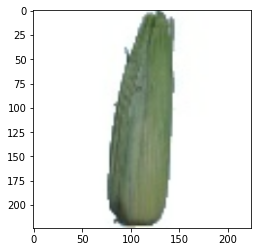

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

709/709 [==============================] - 86s 116ms/step - loss: 0.9067 - accuracy: 0.8452 - precision: 0.8631 - recall: 0.8361
 Testing Acc :  0.8451604247093201
 Testing Precision  0.8630511164665222
 Testing Recall  0.8360807299613953


In [ ]:
def LoadImage(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="bilinear")
    plt.imshow(image.numpy()/255)
    image = tf.expand_dims(image , 0)
    return image

def RealtimePrediction(image_path , model, encoder_):
    image = LoadImage(image_path)
    prediction = model.predict(image)
    prediction = np.argmax(prediction , axis = 1)
    return encoder_.inverse_transform(prediction)[0]

'Pear Monster'

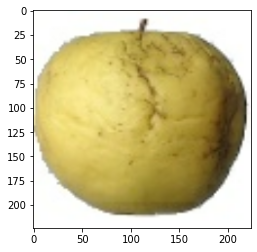

In [ ]:
RealtimePrediction("/tmp/fruits-360/Training/Apple Golden 1/11_100.jpg" , model , Le)